In [1]:
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
import warnings
warnings.filterwarnings('ignore')

Data Collection

In [6]:
df = pd.read_csv('telecom_churn_data.csv')

Data Cleanup

In [7]:
df_clean = df.copy()

Filter high-value customers

In [8]:
df_clean['avg_rech_amt_6_7'] = (df_clean['total_rech_amt_6'] + df_clean['total_rech_amt_7']) / 2
X = df_clean['avg_rech_amt_6_7'].quantile(0.7)
df_clean = df_clean[df_clean['avg_rech_amt_6_7'] >= X]

Null value handling

In [9]:
def null_cleaner(df, percentage):
    null_cols = round((df.isnull().sum() / df.shape[0]) * 100, 4)
    null_cols_gt_percentage = null_cols[null_cols > float(percentage)].index.to_list()
    df_clean = df[~df[null_cols_gt_percentage].isna().all(axis=1)]
    return df_clean

In [10]:
df_clean = null_cleaner(df_clean, 5.0)
df_clean = null_cleaner(df_clean, 1.0)

Dropping unnecessary columns

In [11]:
date_cols = [col for col in df_clean.columns if 'date' in col]
df_clean.drop(date_cols, axis=1, inplace=True)

Dropping columns with single value

In [12]:
single_value_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 1]
df_clean.drop(single_value_cols, axis=1, inplace=True)

Imputing remaining null values with mode

In [13]:
null_cols = round((df_clean.isnull().sum() / df_clean.shape[0]) * 100, 4)
for col in null_cols.index.tolist():
    mode_value = df_clean[col].mode()[0]
    df_clean[col].fillna(mode_value, inplace=True)

Tagging churners

In [14]:
df_clean['churn'] = np.where((df_clean['total_ic_mou_9'] == 0) & (df_clean['total_og_mou_9'] == 0) &
                             (df_clean['vol_2g_mb_9'] == 0) & (df_clean['vol_3g_mb_9'] == 0), 1, 0)

Dropping churn phase columns

In [15]:
churn_cols = [col for col in df_clean.columns if ("_9" in col) or ("sep" in col)]
df_clean.drop(churn_cols, axis=1, inplace=True)

EDA

In [16]:
df_eda = df_clean.copy()

Univariate Analysis

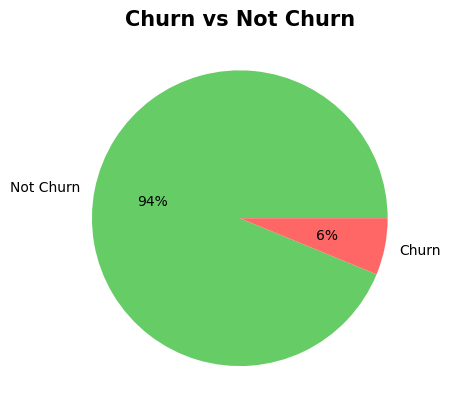

In [17]:
plt.pie(df_eda['churn'].value_counts(), labels=['Not Churn', 'Churn'], autopct='%.0f%%', colors=['#66CC66', '#FF6666'])
plt.title('Churn vs Not Churn', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

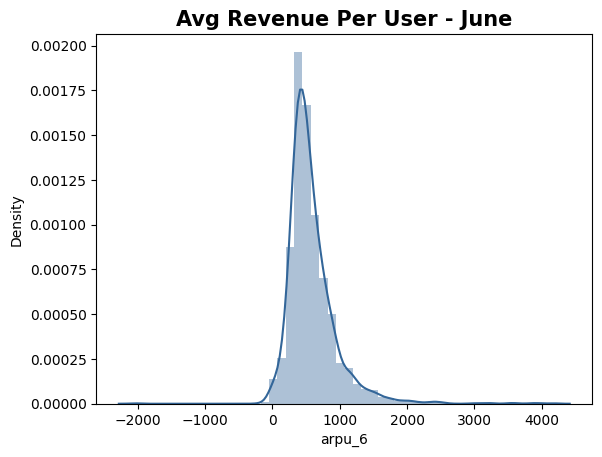

In [18]:
sns.distplot(df_eda['arpu_6'], color='#336699')
plt.title('Avg Revenue Per User - June', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

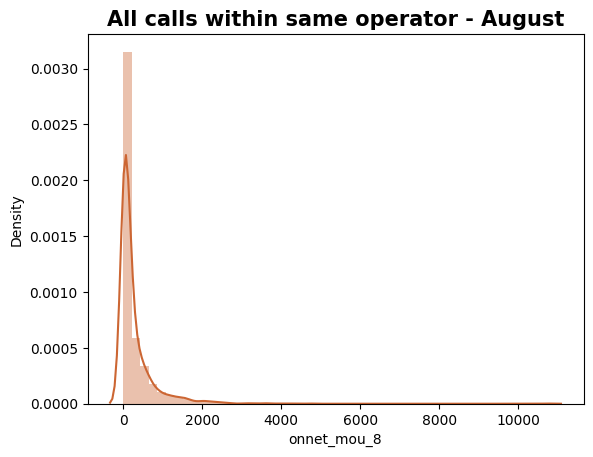

In [19]:
sns.distplot(df_eda['onnet_mou_8'], color='#CC6633')
plt.title('All calls within same operator - August', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

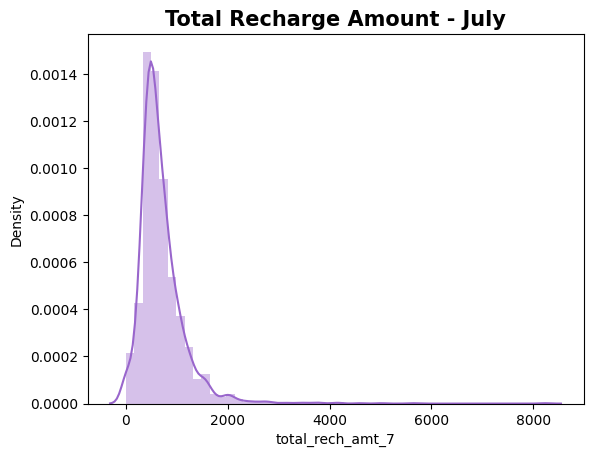

In [20]:
sns.distplot(df_eda['total_rech_amt_7'], color='#9966CC')
plt.title('Total Recharge Amount - July', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

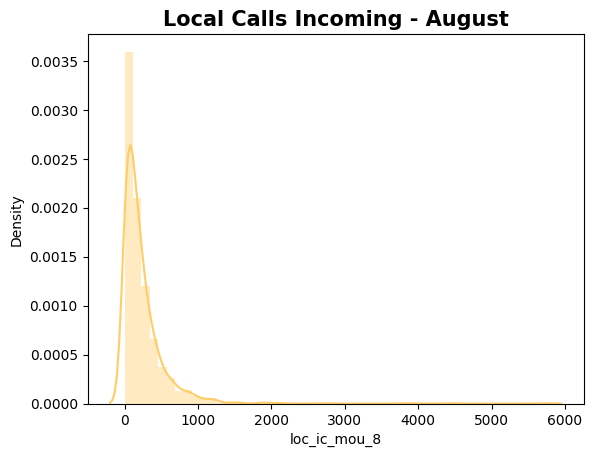

In [21]:
sns.distplot(df_eda['loc_ic_mou_8'], color='#FFCC66')
plt.title('Local Calls Incoming - August', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

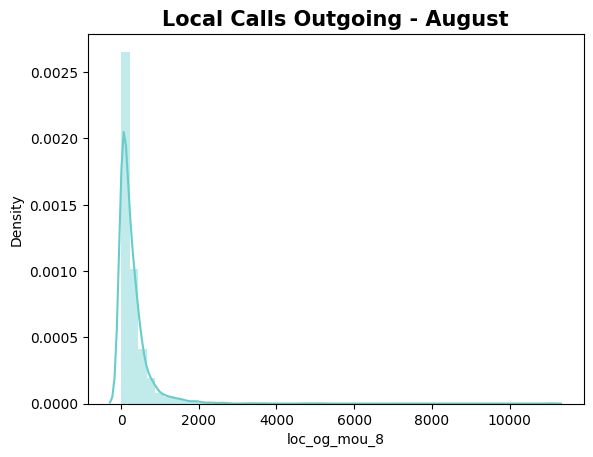

In [22]:
sns.distplot(df_eda['loc_og_mou_8'], color='#66CCCC')
plt.title('Local Calls Outgoing - August', fontdict={'fontsize': '15', 'fontweight': 'bold'})
plt.show()

Bivariate Analysis

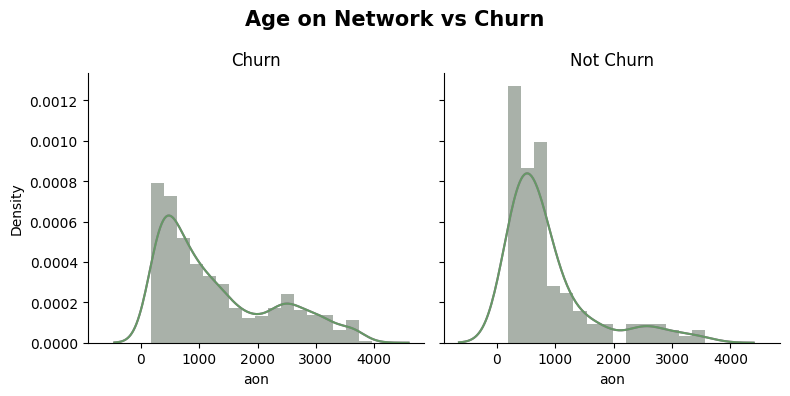

In [23]:
grid = sns.FacetGrid(df_eda, col='churn', height=4)
grid.map(sns.distplot, 'aon', color='#996699')
grid.axes[0, 0].set_title('Churn')
grid.map(sns.distplot, 'aon', color='#669966')
grid.axes[0, 1].set_title('Not Churn')
plt.subplots_adjust(top=1)
plt.suptitle('Age on Network vs Churn', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

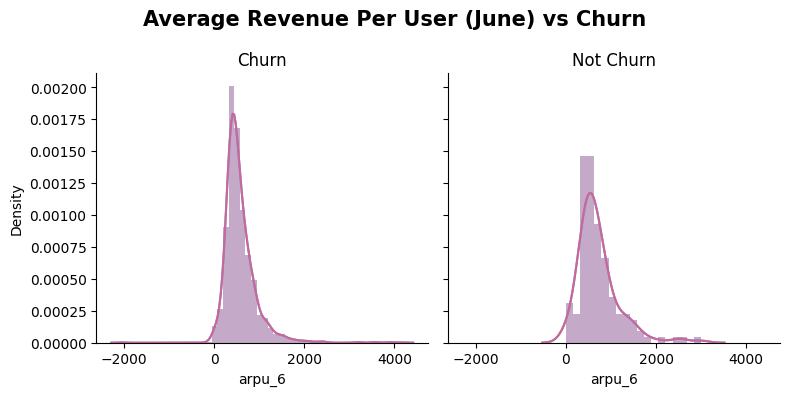

In [24]:
grid = sns.FacetGrid(df_eda, col='churn', height=4)
grid.map(sns.distplot, 'arpu_6', color='#6699CC')
grid.axes[0, 0].set_title('Churn')
grid.map(sns.distplot, 'arpu_6', color='#CC6699')
grid.axes[0, 1].set_title('Not Churn')
plt.subplots_adjust(top=1)
plt.suptitle('Average Revenue Per User (June) vs Churn', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

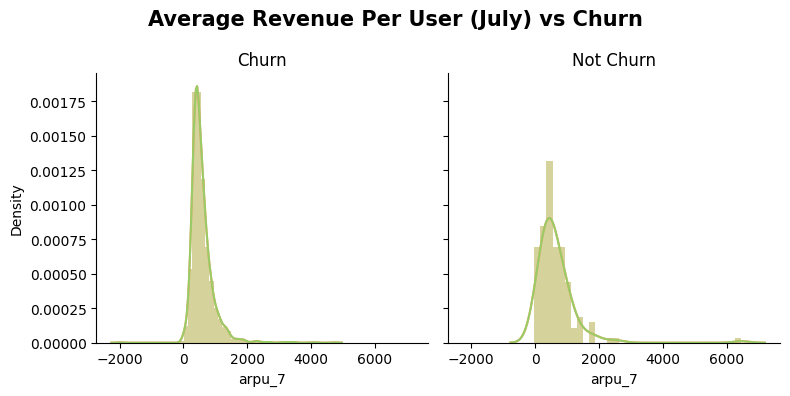

In [25]:
grid = sns.FacetGrid(df_eda, col='churn', height=4)
grid.map(sns.distplot, 'arpu_7', color='#FF9966')
grid.axes[0, 0].set_title('Churn')
grid.map(sns.distplot, 'arpu_7', color='#99CC66')
grid.axes[0, 1].set_title('Not Churn')
plt.subplots_adjust(top=1)
plt.suptitle('Average Revenue Per User (July) vs Churn', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

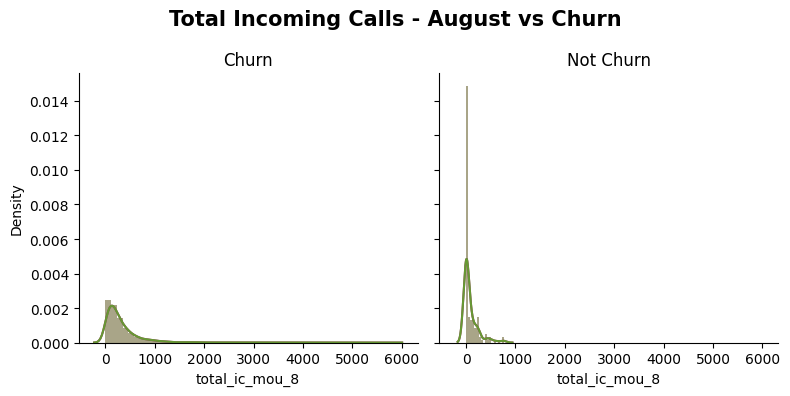

In [26]:
grid = sns.FacetGrid(df_eda, col='churn', height=4)
grid.map(sns.distplot, 'total_ic_mou_8', color='#993366')
grid.axes[0, 0].set_title('Churn')
grid.map(sns.distplot, 'total_ic_mou_8', color='#669933')
grid.axes[0, 1].set_title('Not Churn')
plt.subplots_adjust(top=1)
plt.suptitle('Total Incoming Calls - August vs Churn', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Data Preparation

In [27]:
df_prep = df_clean.copy()

Encoding categorical variables

In [28]:
df_prep = pd.get_dummies(df_prep, columns=['night_pck_user_8', 'fb_user_8'], drop_first=True)

Scaling numerical variables

In [29]:
num_cols = [col for col in df_prep.columns if df_prep[col].dtype != 'O' and col != 'churn']
scaler = StandardScaler()
df_prep[num_cols] = scaler.fit_transform(df_prep[num_cols])

Train-Test Split

In [30]:
X = df_prep.drop('churn', axis=1)
y = df_prep['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

PCA

In [31]:
pca = IncrementalPCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Random Forest with PCA

In [32]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [10, 15, 20],
    'max_depth': [3, 5, 7],
    'min_samples_split': [50, 100, 150],
    'min_samples_leaf': [30, 50, 70],
    'bootstrap': [True, False]
}

In [33]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)

Model Fit

In [34]:
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 5, 7],
                         'max_features': [10, 15, 20],
                         'min_samples_leaf': [30, 50, 70],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

Best Score with Best C Score

In [35]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_

In [36]:
print("Best Score => {0} Best Parameters => {1}".format(round(best_score, 3), best_params))

Best Score => 0.938 Best Parameters => {'bootstrap': True, 'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 30, 'min_samples_split': 50, 'n_estimators': 50}


In [37]:
X_train_pca

array([[-2.33665533,  0.29646525,  2.55768505, ..., -0.2419043 ,
        -0.2824553 , -0.14569049],
       [-2.98723405, -0.75685222,  1.5283129 , ..., -0.55684278,
        -0.08020171, -0.06768773],
       [ 6.36947561, -7.9203999 ,  2.86226301, ..., -0.2016631 ,
        -0.8484208 , -1.83720758],
       ...,
       [ 3.5055514 , -5.59198251,  0.46140509, ..., -0.25142164,
         0.75583152,  0.72256434],
       [-3.17261218,  0.51221669,  2.38923477, ...,  0.99412588,
        -0.10567459,  0.14703184],
       [-3.05076616,  2.05331501,  1.55939815, ...,  0.9350024 ,
        -0.72197162, -1.57750416]])

Model with Optimal Hyperparameters

In [38]:
rf_model = RandomForestClassifier(bootstrap=True,
                                  max_depth=5,
                                  min_samples_leaf=50,
                                  min_samples_split=100,
                                  max_features=20,
                                  n_estimators=100,
                                  random_state=42)

Model Fit

In [39]:
rf_model.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=50,
                       min_samples_split=100, random_state=42)

Feature Importance

In [47]:
# Fit PCA
pca = IncrementalPCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)

In [48]:
# Get PCA component names
n_components = pca.components_.shape[0]
pca_components_names = X_train.columns[:n_components].tolist()

In [49]:
# Feature Importance
importance = rf_model.feature_importances_

In [50]:
# Create DataFrame for Feature Importance
feature_importance = pd.DataFrame({'Variable': pca_components_names, 'Importance': importance * 100})
feature_importance = feature_importance[['Variable', 'Importance']]

In [51]:

# Sort Features based on Importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
print("Total Importance = ", feature_importance.Importance.sum())
feature_importance


Total Importance =  100.00000000000003


,Variable,Importance
0,offnet_mou_6,35.499757
1,roam_ic_mou_7,17.782222
2,mobile_number,8.474502
3,loc_og_t2m_mou_7,5.611347
4,arpu_6,4.197124
5,loc_og_t2f_mou_7,3.232070
6,offnet_mou_7,2.927631
7,std_og_t2t_mou_6,2.699841
8,roam_og_mou_6,2.219193
9,arpu_8,2.085996


Create DataFrame for Feature Importance

Sort Features based on Importance

In [52]:
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
print("Total Importance = ", feature_importance.Importance.sum())
feature_importance

Total Importance =  100.00000000000003


,Variable,Importance
0,offnet_mou_6,35.499757
1,roam_ic_mou_7,17.782222
2,mobile_number,8.474502
3,loc_og_t2m_mou_7,5.611347
4,arpu_6,4.197124
5,loc_og_t2f_mou_7,3.232070
6,offnet_mou_7,2.927631
7,std_og_t2t_mou_6,2.699841
8,roam_og_mou_6,2.219193
9,arpu_8,2.085996


Getting the Top 25 Features

In [53]:
top_features_25 = 25
top_features = feature_importance['Variable'][:top_features_25]

Plot Heatmap of the Top 25 Features

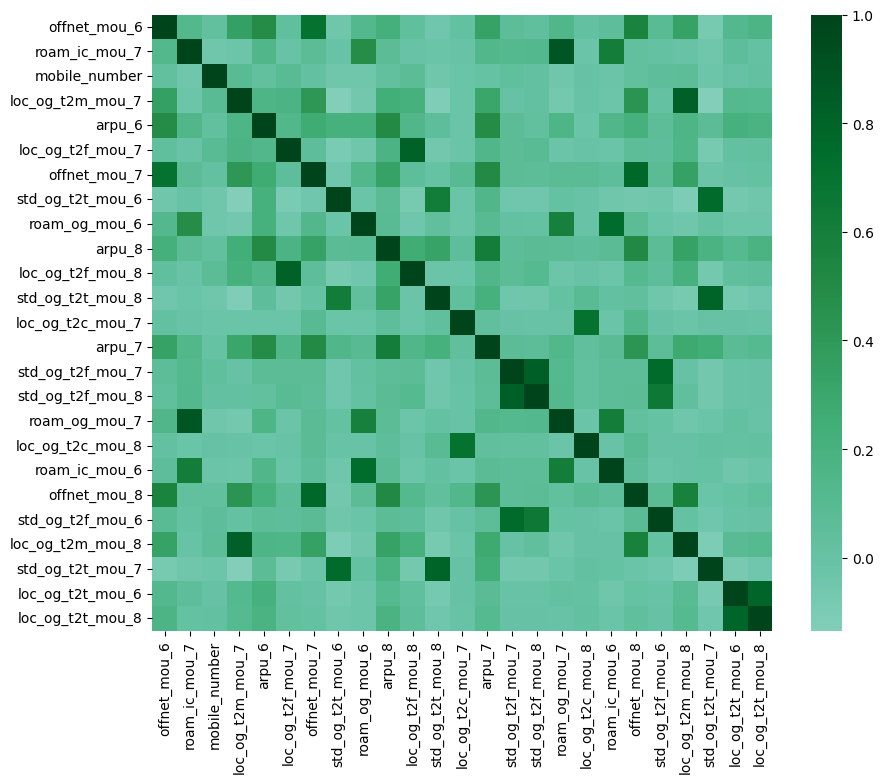

In [54]:
plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap='BuGn')
plt.show()

In [55]:
feature_importance['Variable'][:10].to_list()

['offnet_mou_6',
 'roam_ic_mou_7',
 'mobile_number',
 'loc_og_t2m_mou_7',
 'arpu_6',
 'loc_og_t2f_mou_7',
 'offnet_mou_7',
 'std_og_t2t_mou_6',
 'roam_og_mou_6',
 'arpu_8']

Fitting Logistic Regression Model with Top 10 Features

In [56]:
top_10 = feature_importance['Variable'][:10].to_list()
X_train = X_train[top_10]
X_test = X_test[top_10]

KFold object with 5 splits

In [57]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=51)

Hyperparameter Tuning for Logistic Regression Model

In [58]:
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

In [59]:
model_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=params, scoring='roc_auc', cv=k_fold, verbose=1, return_train_score=True)

Model Fit

In [60]:
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=51, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

Best Hyperparameters

In [61]:
print("Best AUC: ", model_cv.best_score_)
print("Best Hyperparameters: ", model_cv.best_params_)

Best AUC:  0.7850653292362445
Best Hyperparameters:  {'C': 1}


Predict Churn on Test Dataset

In [62]:
y_test_pred = model_cv.predict(X_test)

Confusion Matrix

In [63]:
conf_matrx = metrics.confusion_matrix(y_test, y_test_pred)
print(conf_matrx)

[[647   3]
 [ 39   4]]


In [64]:
TP = conf_matrx[1, 1]  # True Positive
TN = conf_matrx[0, 0]  # True Negative
FP = conf_matrx[0, 1]  # False Positive
FN = conf_matrx[1, 0]  # False Negative

Accuracy

In [65]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

Accuracy:  0.9393939393939394


Sensitivity

In [66]:
print("Sensitivity: ", TP / float(TP + FN))

Sensitivity:  0.09302325581395349


Specificity

In [67]:
print("Specificity: ", TN / float(TN + FP))

Specificity:  0.9953846153846154


In [68]:
logreg_model = model_cv.best_estimator_

Intercept

In [69]:
intercept_df = pd.DataFrame(logreg_model.intercept_.reshape((1, 1)), columns=['Intercept'])

In [70]:
intercept_df

,Intercept
0,-3.47595


Coefficients

In [71]:
coefficients = logreg_model.coef_.reshape((len(top_10), 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

In [72]:
logistic_features = list(X_train.columns)
coefficients_df = pd.DataFrame(logreg_model.coef_, columns=logistic_features)

Merge DataFrames

In [73]:
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,Intercept,offnet_mou_6,roam_ic_mou_7,mobile_number,loc_og_t2m_mou_7,arpu_6,loc_og_t2f_mou_7,offnet_mou_7,std_og_t2t_mou_6,roam_og_mou_6,arpu_8
0,-3.47595,-0.166061,0.399246,-0.078008,-0.440913,0.613219,-0.177756,0.379946,0.095163,0.07306,-1.620822


Business Insights

In [74]:
business_insights = {
    'Total Incoming Minutes of Usage': 'Business should consider strategies to encourage more incoming calls, such as attractive call packages or promotional offers.',
    'STD Outgoing Minutes of Usage in August': 'This implies that customers who make more STD outgoing calls in August tend to have a higher value or engagement with your business. Business should leverage this insight to offer targeted STD calling plans or special promotions during this period to encourage customer engagement.',
    'STD Incoming Minutes of Usage in July': 'This indicates that customers who receive more STD incoming calls during this month tend to have a higher value or engagement. Business can focus on enhancing customer experience for STD incoming calls, such as providing better call quality, reliable connections, and attractive STD incoming call packages.',
    'Roaming Outgoing Minutes of Usage in July': 'It indicates that customers who make more outgoing calls while in roaming during this month tend to be more valuable. Business should consider providing special roaming offers, affordable international calling rates, or tailored packages to cater to the needs of customers who frequently travel or use roaming services.',
    'On-net Minutes of Usage in June': 'Business may want to investigate and find ways to encourage customers to diversify their calling patterns or explore other services within the business.',
    'STD Outgoing Minutes of Usage to Fixed Lines in August': 'Business should analyze strategies to improve the value proposition for customers making STD calls to fixed lines, such as offering bundled packages or discounted rates for these types of calls.',
    'ISD Incoming Minutes of Usage in July': 'This indicates that customers who receive more ISD incoming calls during this month tend to have a higher value or engagement. Consider offering attractive ISD incoming call plans, competitive international calling rates, or promotions to cater to the needs of customers with international connections.',
    'Local Outgoing Minutes of Usage to Other Operator Mobiles in July': 'Business should consider strategies to improve the attractiveness of your local outgoing call offerings to customers using other operator mobiles. This could include competitive pricing, value-added services, or targeted marketing campaigns.',
    'Special Outgoing Minutes of Usage in July': 'Consider evaluating the nature and purpose of these special outgoing calls and identifying ways to enhance their value or relevance for customers. Business could introduce customized special call packages, exclusive features, or discounts to encourage customers to make more special outgoing calls.',
    '2G Sachet Recharge in July': 'This suggests that customers who opt for 2G sachet recharges during this month tend to have a lower value or engagement. Business may want to analyze the reasons behind this trend and consider promoting higher-speed data services or encouraging customers to upgrade to more advanced data plans.'
}

In [76]:
from tabulate import tabulate

# Create DataFrame
business_insights_df = pd.DataFrame.from_dict(business_insights, orient='index', columns=['Insights'])

# Print DataFrame in tabular format
print(tabulate(business_insights_df, headers='keys', tablefmt='psql'))


+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                   | Insights                                                                                                                                                                                                                                                                                                                        |
|-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------